In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import math

In [36]:
df_train_set = pd.read_csv('modeling-data/train-data.csv')
df_test_set = pd.read_csv('modeling-data/test-data.csv')
df_submission_set = pd.read_csv('modeling-data/submission-data.csv')

# Data Prep

In [37]:
# Prepare training data
X_train = df_train_set.loc[:, df_train_set.columns != 'DaysInHospital']
Y_train = df_train_set['DaysInHospital']

X_train = X_train.drop(['Year', 'MemberID'], axis=1)

In [38]:
# Preapre test data
X_test = df_test_set.loc[:, df_test_set.columns != 'DaysInHospital']
Y_test = df_test_set['DaysInHospital']

X_test = X_test.drop(['Year', 'MemberID'], axis=1)

In [39]:
# Preapre submission data
X_sub = df_submission_set.loc[:, df_submission_set.columns != 'DaysInHospital']
Y_sub = df_submission_set['DaysInHospital']

X_sub = X_sub.drop(['Year', 'MemberID'], axis=1)

In [40]:
#Scaling
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_sub = scaler.transform(X_sub)

In [41]:
# Create evaluation function
def eval(model, X_test, Y_test):
    pred_Y = model.predict(X_test) # your predicted y values
    pred_Y = pred_Y.clip(min=0)
    pred_Y = pred_Y.astype(int)
    # The root mean square logarithmic error
    msle = np.mean( (np.log(pred_Y + 1) - np.log(Y_test + 1)) ** 2)
    rmsle = math.sqrt(msle)
    
    print ("RMSLE: %.4f" % rmsle)
    from sklearn.metrics import r2_score
    r2 = r2_score(pred_Y, Y_test)
    print ("R2 value: %.4f" % r2)

In [46]:
# Model testing
# ML Algo used: Gradient Boosting algorithm
# Compute the accuracy scores on training and test sets when training with different learning rates

learning_rates = [0.16, 0.17, 0.18, 0.2, 0.21, 0.22, 0.3]
for learning_rate in learning_rates:
    model_gbm = ensemble.GradientBoostingRegressor(n_estimators=20, learning_rate = learning_rate, max_features=4, max_depth = 4, random_state = 0)
    model_gbm.fit(X_train, Y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training set): {0:.3f}".format(model_gbm.score(X_train, Y_train)))
    print("Accuracy score (test set): {0:.3f}".format(model_gbm.score(X_test, Y_test)))
    print()

Learning rate:  0.16
Accuracy score (training set): 0.085
Accuracy score (test set): 0.066

Learning rate:  0.17
Accuracy score (training set): 0.087
Accuracy score (test set): 0.068

Learning rate:  0.18
Accuracy score (training set): 0.088
Accuracy score (test set): 0.069

Learning rate:  0.2
Accuracy score (training set): 0.092
Accuracy score (test set): 0.067

Learning rate:  0.21
Accuracy score (training set): 0.092
Accuracy score (test set): 0.069

Learning rate:  0.22
Accuracy score (training set): 0.096
Accuracy score (test set): 0.068

Learning rate:  0.3
Accuracy score (training set): 0.102
Accuracy score (test set): 0.060



After trying with different learning rates, the one that give the highest accuracy score on test set is **0.21**. We will build our actual model with this learning rate.

In [47]:
# Model Training
model_gbm = ensemble.GradientBoostingRegressor(n_estimators=20, learning_rate = 0.21, max_features=4, max_depth = 4, random_state = 0)
model_gbm.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.21, max_depth=4, max_features=4,
                          n_estimators=20, random_state=0)

# Model Evaluation

### On Test Data

In [48]:
# Model evaluation on Test Data
eval(model_gbm, X_test, Y_test)

RMSLE: 0.4875
R2 value: -16.8879


### On Submission Data

In [49]:
# Model evaluation on Submission Data
eval(model_gbm, X_sub, Y_sub)

RMSLE: 0.4903
R2 value: -17.4047


# Prediction Results

In [50]:
# Prediction Result
pred_Y = model_gbm.predict(X_sub).clip(min=0)
df_predicted = pd.DataFrame()
df_predicted['Year'] = df_submission_set['Year']
df_predicted['MemberID'] = df_submission_set['MemberID']
df_predicted['DaysInHospital_predicted'] = pred_Y
df_predicted['DaysInHospital_actual'] = df_submission_set['DaysInHospital']

### Some results

In [51]:
df_predicted[df_predicted['DaysInHospital_actual'] >= 1].sample(20)

,Year,MemberID,DaysInHospital_predicted,DaysInHospital_actual
2154,Y2,23014289,0.496494,3
22858,Y2,92583886,0.936995,2
24688,Y2,84594671,0.574865,3
21137,Y2,14094094,0.604351,1
24325,Y2,35078584,0.202840,1
3084,Y2,24206801,0.483851,1
14999,Y2,49936973,0.753989,10
14701,Y2,90073152,0.149499,2
28939,Y2,20849970,0.310897,1
14830,Y2,51092404,0.768134,3



### Distribution of Predicted DaysInHospital Values

In [56]:
# Predicted number of members who have DaysInHospital > 0,5
len(df_predicted[df_predicted['DaysInHospital_predicted'] > 0.5])

9368

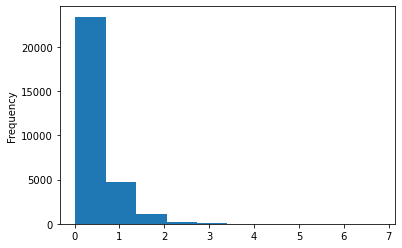

In [53]:
df_predicted['DaysInHospital_predicted'].plot.hist()

### Distribution of Actual DaysInHospital Values

In [54]:
# Actual number of members who have to stay at least 1 day in the hospital
len(df_predicted[df_predicted['DaysInHospital_actual'] >= 1])

4365

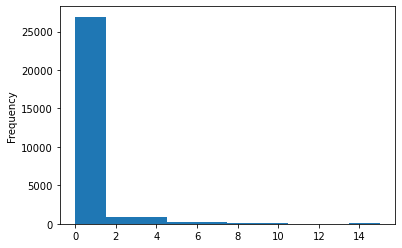

In [55]:
df_predicted['DaysInHospital_actual'].plot.hist()